In [1]:
# Refs: 
# 1. https://github.com/karpathy/micrograd/tree/master/micrograd
# 2. https://github.com/mattjj/autodidact
# 3. https://github.com/mattjj/autodidact/blob/master/autograd/numpy/numpy_vjps.py
from collections import namedtuple
import numpy as np


def unbroadcast(target, g, axis=0):
    """Remove broadcasted dimensions by summing along them.
    When computing gradients of a broadcasted value, this is the right thing to
    do when computing the total derivative and accounting for cloning.
    """
    while np.ndim(g) > np.ndim(target):
        g = g.sum(axis=axis)
    for axis, size in enumerate(target.shape):
        if size == 1:
            g = g.sum(axis=axis, keepdims=True)
    if np.iscomplexobj(g) and not np.iscomplex(target):
        g = g.real()
    return g

Op = namedtuple('Op', ['apply',
                   'vjp',
                   'name',
                   'nargs'])

## Vector Jacobian Product for addition
$\newcommand{\bfa}{\mathbf{a}}$
$\newcommand{\bfb}{\mathbf{b}}$
$\newcommand{\bfA}{\mathbf{A}}$
$\newcommand{\bfB}{\mathbf{B}}$
$\newcommand{\bfC}{\mathbf{C}}$
$\newcommand{\bfF}{\mathbf{F}}$
$\newcommand{\bff}{\mathbf{f}}$
$\newcommand{\bbR}{\mathbb{R}}$
$\newcommand{\bfI}{\mathbf{I}}$
$\newcommand{\bfzero}{\mathbf{0}}$
$\newcommand{\p}{\partial}$

$$\bff(\bfa, \bfb) = \bfa + \bfb$$ where $\bfa, \bfb, \bff \in \bbR^n$

Let $l(\bff(\bfa, \bfb)) \in \bbR$ be the eventual scalar output. We find $\frac{\p l}{\p \bfa}$ and $\frac{\p l}{\p \bfb}$ for Vector Jacobian product.
$$\frac{\p }{\p \bfa} l(\bff(\bfa, \bfb)) = \frac{\p l}{\p \bff}\frac{\p }{\p \bfa}(\bfa + \bfb)
= \frac{\p l}{\p \bff} (\bfI_{n \times n} + 0_{n \times n}) = \frac{\p l}{\p \bff}$$ 

Similarly, 
$$\frac{\p }{\p \bfb} l(\bff(\bfa, \bfb)) = \frac{\p l}{\p \bff}$$


In [2]:
def add_vjp(dldf, a, b):
    dlda = unbroadcast(a, dldf)
    dldb = unbroadcast(b, dldf)
    return dlda, dldb
    
add = Op(
    apply=np.add,
    vjp=add_vjp,
    name='+',
    nargs=2)

## VJP for element-wise multiplication

<!-- $$\bff(\alpha, \bfb) = \alpha \bfb$$ where $\alpha \in \bbR,  and \bfb, \bff \in \bbR^n$

Let $l(\bff(\alpha, \bfb)) \in \bbR$ be the eventual scalar output. We find $\frac{\p l}{\p \alpha}$ and $\frac{\p l}{\p \bfb}$ for Vector Jacobian product.
$$\frac{\p }{\p \alpha} l(\bff(\alpha, \bfb)) = \frac{\p l}{\p \bff}\frac{\p }{\p \alpha}(\alpha \bfb)
= \frac{\p l}{\p \bff} \bfb$$ 

Similarly, 
$$\frac{\p }{\p \bfb} l(\bff(\alpha, \bfb)) = \frac{\p l}{\p \bff}\alpha I_{n \times n}$$ -->

$$f(\alpha, \beta) = \alpha \beta$$ where $\alpha, \beta, f \in \bbR$

Let $l(f(\alpha, \beta)) \in \bbR$ be the eventual scalar output. We find $\frac{\p l}{\p \alpha}$ and $\frac{\p l}{\p \beta}$ for Vector Jacobian product.

$$\frac{\p }{\p \alpha} l(f(\alpha, \beta)) = \frac{\p l}{\p f}\frac{\p }{\p \alpha}(\alpha \beta)
= \frac{\p l}{\p f} \beta$$ 
$$\frac{\p }{\p \beta} l(f(\alpha, \beta)) = \frac{\p l}{\p f}\frac{\p }{\p \beta}(\alpha \beta)
= \frac{\p l}{\p f} \alpha$$ 


In [3]:
def mul_vjp(dldf, a, b):
    dlda = unbroadcast(a, dldf * b)
    dldb = unbroadcast(b, dldf * a)
    return dlda, dldb

mul = Op(
    apply=np.multiply,
    vjp=mul_vjp,
    name='*',
    nargs=2)

## VJP for matrix-matrix, matrix-vector and vector-vector multiplication

### Case 1: VJP for vector-vector multiplication

$$f(\bfa, \bfb) = \bfa^\top \bfb$$ where $f \in \bbR$,  and $\bfb, \bfa \in \bbR^n$

Let $l(f(\bfa, \bfb)) \in \bbR$ be the eventual scalar output. We find $\frac{\p l}{\p \bfa}$ and $\frac{\p l}{\p \bfb}$ for Vector Jacobian product.
$$\frac{\p }{\p \bfa} l(f(\bfa, \bfb)) = \frac{\p l}{\p f}\frac{\p }{\p \bfa}(\bfa^\top \bfb)
= \frac{\p l}{\p f} \bfb^\top$$ 

Similarly, 
$$\frac{\p }{\p \bfb} l(f(\bfa, \bfb)) = \frac{\p l}{\p f}\bfa^\top$$ 

### Case 2: VJP for matrix-vector multiplication

Let
$$\bff(\bfA, \bfb) = \bfA \bfb$$ where $\bff \in \bbR^m$, $\bfb \in \bbR^n$, and $\bfA \in \bbR^{m \times n}$

Let $l(\bff(\bfA, \bfb)) \in \bbR$ be the eventual scalar output. We want to findfind $\frac{\p l}{\p \bfA}$ and $\frac{\p l}{\p \bfb}$ for Vector Jacobian product.


Let 
$$ \bfA = \begin{bmatrix}
a_{11} & a_{12} & \dots & a_{1n}\\
a_{21} & a_{22} & \dots & a_{2n}\\
\vdots & \vdots & \ddots & \vdots \\
a_{m1} & a_{m2} & \dots & a_{mn}
\end{bmatrix} 
= \begin{bmatrix}
\bfa_1^\top\\
\bfa_2^\top\\
\vdots\\
\bfa_m^\top
\end{bmatrix}$$, where each $\bfa_i^\top \in \bbR^{1 \times n}$ and $a_{ij} \in \bbR$.

Define matrix derivative of  scalar to be:
$$ \frac{\p l}{\p \bfA} = \begin{bmatrix}
\frac{\p l}{\p a_{11}} & \frac{\p l}{\p a_{12}} & \dots & \frac{\p l}{\p a_{1n}}\\
\frac{\p l}{\p a_{21}} & \frac{\p l}{\p a_{22}} & \dots & \frac{\p l}{\p a_{2n}}\\
\vdots & \vdots & \ddots & \vdots \\
\frac{\p l}{\p a_{m1}} & \frac{\p l}{\p a_{m2}} & \dots & \frac{\p l}{\p a_{mn}}
\end{bmatrix}
=
\begin{bmatrix}
\frac{\p l}{\p \bfa_1}\\
\frac{\p l}{\p \bfa_2}\\
\vdots\\
\frac{\p l}{\p \bfa_m}
\end{bmatrix}
$$


$$\frac{\p }{\p \bfA} l(\bff(\bfa, \bfb)) = \frac{\p l}{\p \bff} \frac{\p }{\p \bfA} (\bfA\bfb)$$.

Note that $$\bfA\bfb = 
\begin{bmatrix}
\bfa_1^\top\\
\bfa_2^\top\\
\vdots\\
\bfa_m^\top
\end{bmatrix}\bfb 
= 
\begin{bmatrix}
\bfa_1^\top\bfb\\
\bfa_2^\top\bfb\\
\vdots\\
\bfa_m^\top\bfb
\end{bmatrix}
$$

Since $\bfa_i^\top \bfb$ is a scalar, it is easier to find its derivative with respect to the matrix $\bfA$.

$$\frac{\p }{\p \bfA}\bfa_i^\top \bfb 
= \begin{bmatrix}
\frac{\p \bfa_i^\top \bfb }{\p \bfa_1}\\
\frac{\p \bfa_i^\top \bfb }{\p \bfa_2}\\
\vdots\\
\frac{\p \bfa_i^\top \bfb }{\p \bfa_i}\\
\vdots\\
\frac{\p \bfa_i^\top \bfb }{\p \bfa_m}
\end{bmatrix} 
= \begin{bmatrix}
\bfzero^\top_{n}\\
\bfzero^\top_{n}\\
\vdots\\
\bfb^\top\\
\vdots\\
\bfzero^\top_{n}
\end{bmatrix}
\in \bbR^{m \times n}$$

Let 
$$\frac{\p l}{\p \bff} = \begin{bmatrix} \frac{\p l}{\p f_1} & \frac{\p l}{\p f_2} & \dots & \frac{\p l}{\p f_m} \end{bmatrix}$$

Then $$\frac{\p l}{\p \bff}\frac{\p }{\p \bfA}\bfa_i^\top \bfb = 
\begin{bmatrix} \frac{\p l}{\p f_1} & \frac{\p l}{\p f_2} & \dots & \frac{\p l}{\p f_m} \end{bmatrix}
\begin{bmatrix}
\bfzero^\top_{n}\\
\bfzero^\top_{n}\\
\vdots\\
\bfb^\top\\
\vdots\\
\bfzero^\top_{n}
\end{bmatrix}
= \frac{\p l}{\p f_i}\bfb^\top \in \bbR^{1 \times n}$$

Returning to our original quest for 
$$ \frac{\p }{\p \bfA} l(\bff(\bfA, \bfb)) = \frac{\p l}{\p \bff}\frac{\p }{\p \bfA}\bfA \bfb = 
\frac{\p l}{\p \bff}\frac{\p }{\p \bfA}
\begin{bmatrix}
\bfa_1^\top\bfb\\
\bfa_2^\top\bfb\\
\vdots\\
\bfa_m^\top\bfb
\end{bmatrix}
=
\begin{bmatrix}
\frac{\p l}{\p \bff}\frac{\p }{\p \bfA}\bfa_1^\top\bfb\\
\frac{\p l}{\p \bff}\frac{\p }{\p \bfA}\bfa_2^\top\bfb\\
\vdots\\
\frac{\p l}{\p \bff}\frac{\p }{\p \bfA}\bfa_m^\top\bfb
\end{bmatrix}
=
\begin{bmatrix}
\frac{\p l}{\p f_1}\bfb^\top\\
\frac{\p l}{\p f_2}\bfb^\top\\
\vdots\\
\frac{\p l}{\p f_m}\bfb^\top
\end{bmatrix}
$$

Note that 
$$  
\begin{bmatrix}
\frac{\p l}{\p f_1}\bfb^\top\\
\frac{\p l}{\p f_2}\bfb^\top\\
\vdots\\
\frac{\p l}{\p f_m}\bfb^\top
\end{bmatrix}
= \begin{bmatrix} \frac{\p l}{\p f_1} \\ \frac{\p l}{\p f_2} \\ \dots \\ \frac{\p l}{\p f_m} \end{bmatrix} \bfb^\top 
= \left(\frac{\p l}{\p \bff}\right)^\top \bfb^\top
$$

We can group the terms inside a single transpose.

Which results in
$$ \frac{\p }{\p \bfA} l(\bff(\bfA, \bfb)) = \left(\bfb\frac{\p l}{\p \bff}\right)^\top$$

The derivative with respect to $\bfb$ is simpler:
$$ \frac{\p }{\p \bfb} l(\bff(\bfA, \bfb)) = \frac{\p l}{\p \bff}\frac{\p }{\p \bfb}(\bfA\bfb) = \frac{\p l}{\p \bff} \bfA$$

### Case 3: VJP for matrix-matrix multiplication

Let
$$\bfF(\bfA, \bfB) = \bfA \bfB$$ where $\bfF \in \bbR^{m \times p}$, $\bfB \in \bbR^{n \times p}$, and $\bfA \in \bbR^{m \times n}$

Let $l(\bfF(\bfA, \bfB)) \in \bbR$ be the eventual scalar output. We want to find $\frac{\p l}{\p \bfA}$ and $\frac{\p l}{\p \bfB}$ for Vector Jacobian product.


Note that a matrix-matrix multiplication can be written in terms horizontal stacking of matrix-vector multiplications. Specifically, write $\bfF$ and $\bfB$ in terms of their column vectors:
$$\bfB = \begin{bmatrix} \bfb_1 & \bfb_2 & \dots & \bfb_p \end{bmatrix}$$
$$\bfF = \begin{bmatrix} \bff_1 & \bff_2 & \dots & \bff_p \end{bmatrix}.$$

Then for all $i$ 
$$\bff_i = \bfA\bfb_i$$

From the VJP of matrix-vector multiplication, we can write
$$ \frac{\p l}{\p \bff_i}\frac{\p }{\p \bfA}\bff_i =
\frac{\p l}{\p \bff_i}\frac{\p }{\p \bfA}(\bfA \bfb_i) = \left(\bfb_i\frac{\p l}{\p \bff_i}\right)^\top \in \bbR^{ m \times n }$$
and for all $i \ne j$
$$ \frac{\p l}{\p \bff_j}\frac{\p }{\p \bfA}(\bfA \bfb_i) = \bfzero_{m \times n}$$

Instead of writing $l(\bfF)$, we can also write $l(\bff_1, \bff_2, \dots, \bff_p)$, then by chain rule of functions with multiple arguments, we have,
$$\frac{\p }{\p \bfA}l(\bfF(\bfA, \bfB)) = \frac{\p }{\p \bfA} l(\bff_1, \bff_2, \dots, \bff_p)
= \frac{\p l}{\p \bff_1} \frac{\p \bff_1}{\p \bfA} + \frac{\p l}{\p \bff_2} \frac{\p \bff_2}{\p \bfA} + \dots + \frac{\p l}{\p \bff_p} \frac{\p \bff_p}{\p \bfA}$$

$$ \frac{\p }{\p \bfA}l(\bfF(\bfA, \bfB)) = 
 \left(\bfb_1\frac{\p l}{\p \bff_1}\right)^\top 
 + \left(\bfb_2\frac{\p l}{\p \bff_2}\right)^\top 
 + \dots
+ \left(\bfb_p\frac{\p l}{\p \bff_p}\right)^\top 
=
 \left(\bfb_1\frac{\p l}{\p \bff_1}
 + \bfb_2\frac{\p l}{\p \bff_2}
 + \dots
+ \bfb_p\frac{\p l}{\p \bff_p}\right)^\top 
$$

It turns out that some of outer products can be compactly written as matrix-matrix multiplication:
$$ \bfb_1\frac{\p l}{\p \bff_1}
 + \bfb_2\frac{\p l}{\p \bff_2}
 + \dots
+ \bfb_p\frac{\p l}{\p \bff_p} = 
\begin{bmatrix}
\bfb_1 & \bfb_2 & \dots & \bfb_p \end{bmatrix}
\begin{bmatrix}
\frac{\p l}{\p \bff_1}\\
\frac{\p l}{\p \bff_2}\\
\vdots\\
\frac{\p l}{\p \bff_p}\end{bmatrix} = \bfB \left(\frac{\p l}{\p \bfF}\right)^\top$$

Hence,
$$ \frac{\p }{\p \bfA}l(\bfF(\bfA, \bfB)) = \frac{\p l}{\p \bfF}\bfB^\top $$


The vector Jacobian product for $\bfB$ can be found by applying the above rule to $\bfF_2(\bfA, \bfC) = \bfF^\top(\bfA, \bfB) = \bfB^\top \bfA^\top = \bfC \bfA^\top$ where $\bfC = \bfB^\top$ and $\bfF_2 = \bfF^\top$.

$$ \frac{\p }{\p \bfC}l(\bfF_2(\bfA, \bfC)) = \frac{\p l}{\p \bfF_2}\bfA $$

Take transpose of both sides
$$ \frac{\p }{\p \bfC^\top}l(\bfF_2^\top(\bfA, \bfC)) = \bfA^\top\frac{\p l}{\p \bfF_2^\top} $$

Put back, $\bfC = \bfB^\top$ and $\bfF_2 = \bfF^\top$,
$$ \frac{\p }{\p \bfB}l(\bfF(\bfA, \bfB)) = \bfA^\top\frac{\p l}{\p \bfF} $$

In [4]:
def matmul_vjp(dldF, A, B):
    G = dldF
    if G.ndim == 0:
        # Case 1: vector-vector multiplication
        assert A.ndim == 1 and B.ndim == 1
        dldA = G*B
        dldB = G*A
        return (unbroadcast(A, dldA),
                unbroadcast(B, dldB))
    
    assert not (A.ndim == 1 and B.ndim == 1)

    # 1. If both arguments are 2-D they are multiplied like conventional matrices.
    # 2. If either argument is N-D, N > 2, it is treated as a stack of matrices 
    # residing in the last two indexes and broadcast accordingly.
    if A.ndim >= 2 and B.ndim >= 2:
        dldA = G @ B.swapaxes(-2, -1)
        dldB = A.swapaxes(-2, -1) @ G
    if A.ndim == 1:
        # 3. If the first argument is 1-D, it is promoted to a matrix by prepending a
        #    1 to its dimensions. After matrix multiplication the prepended 1 is removed.
        A_ = A[np.newaxis, :]
        G_ = G[np.newaxis, :]
        dldA = G @ B.swapaxes(-2, -1) 
        dldB = A_.swapaxes(-2, -1) @ G_ # outer product
    elif B.ndim == 1:
        # 4. If the second argument is 1-D, it is promoted to a matrix by appending 
        #    a 1 to its dimensions. After matrix multiplication the appended 1 is removed.
        B_ = B[:, np.newaxis]
        G_ = G[:, np.newaxis]
        dldA = G_ @ B_.swapaxes(-2, -1) # outer product
        dldB = A.swapaxes(-2, -1) @ G
    return (unbroadcast(A, dldA), 
            unbroadcast(B, dldB))
        

matmul = Op(
    apply=np.matmul,
    vjp=matmul_vjp,
    name='@',
    nargs=2)

In [5]:
def exp_vjp(dldf, x):
    dldx = dldf * np.exp(x)
    return (unbroadcast(x, dldx),)
exp = Op(
    apply=np.exp,
    vjp=exp_vjp,
    name='exp',
    nargs=1)

In [6]:
def log_vjp(dldf, x):
    dldx = dldf / x
    return (unbroadcast(x, dldx),)
log = Op(
    apply=np.log,
    vjp=log_vjp,
    name='log',
    nargs=1)

In [7]:
def sum_vjp(dldf, x, axis=None, **kwargs):
    if axis is not None:
        dldx = np.expand_dims(dldf, axis=axis) * np.ones_like(x)
    else:
        dldx = dldf * np.ones_like(x)
    return (unbroadcast(x, dldx),)

sum_ = Op(
    apply=np.sum,
    vjp=sum_vjp,
    name='sum',
    nargs=1)

In [18]:
def maximum_vjp(dldf, a, b):
    dlda = dldf * np.where(a > b, 1, 0)
    dldb = dldf * np.where(a > b, 0, 1)
    return unbroadcast(a, dlda), unbroadcast(b, dldb)

maximum = Op(
    apply=np.maximum,
    vjp=maximum_vjp,
    name='maximum',
    nargs=2)

In [19]:
NoOp = Op(apply=None, name='', vjp=None, nargs=0)
class Tensor:
    __array_priority__ = 100
    def __init__(self, value, grad=None, parents=(), op=NoOp, kwargs={}, requires_grad=True):
        self.value = np.asarray(value)
        self.grad = grad
        self.parents = parents
        self.op = op
        self.kwargs = kwargs
        self.requires_grad = requires_grad
    
    shape = property(lambda self: self.value.shape)
    ndim  = property(lambda self: self.value.ndim)
    size  = property(lambda self: self.value.size)
    dtype = property(lambda self: self.value.dtype)
    
    def __add__(self, other):
        cls = type(self)
        other = other if isinstance(other, cls) else cls(other)
        return cls(add.apply(self.value, other.value),
                   parents=(self, other),
                   op=add)
    __radd__ = __add__
    
    def __mul__(self, other):
        cls = type(self)
        other = other if isinstance(other, cls) else cls(other)
        return cls(mul.apply(self.value, other.value),
                   parents=(self, other),
                   op=mul)
    __rmul__ = __mul__
    
    def __matmul__(self, other):
        cls = type(self)
        other = other if isinstance(other, cls) else cls(other)
        return cls(matmul.apply(self.value, other.value),
                  parents=(self, other),
                  op=matmul)
    
    def exp(self):
        cls = type(self)
        return cls(exp.apply(self.value),
                parents=(self,),
                op=exp)
    
    def log(self):
        cls = type(self)
        return cls(log.apply(self.value),
                parents=(self, ),
                op=log)
    
    def __pow__(self, other):
        cls = type(self)
        other = other if isinstance(other, cls) else cls(other)
        return (self.log() * other).exp()
    
    def __div__(self, other):
        return self * (other**(-1))
    
    def __sub__(self, other):
        return self + (other * (-1))
    
    def __neg__(self):
        return self*(-1)
    
    def sum(self, axis=None):
        cls = type(self)
        return cls(sum_.apply(self.value, axis=axis),
                   parents=(self,),
                   op=sum_,
                   kwargs=dict(axis=axis))

    def maximum(self, other):
        cls = type(self)
        other = other if isinstance(other, cls) else cls(other)
        return cls(maximum.apply(self.value, other.value),
                   parents=(self, other),
                   op=maximum)
        
    def __repr__(self):
        cls = type(self)
        return f"{cls.__name__}(value={self.value}, op={self.op.name})" if self.parents else f"{cls.__name__}(value={self.value})"
        #return f"{cls.__name__}(value={self.value}, parents={self.parents}, op={self.op}"
    
    def backward(self, grad):
        self.grad = grad if self.grad is None else (self.grad+grad)
        if self.requires_grad and self.parents:
            p_vals = [p.value for p in self.parents]
            assert len(p_vals) == self.op.nargs
            p_grads = self.op.vjp(grad, *p_vals, **self.kwargs)
            for p, g in zip(self.parents, p_grads):
                p.backward(g)

In [20]:
Tensor([1, 2]).sum()

Tensor(value=3, op=sum)

In [68]:

try:
    from graphviz import Digraph
except ImportError as e:
    import subprocess
    subprocess.call("pip install --user graphviz".split())

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for p in v.parents:
                edges.add((p, v))
                build(p)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        vstr = np.array2string(np.asarray(n.value), precision=4)
        gradstr= np.array2string(np.asarray(n.grad), precision=4)
        dot.node(name=str(id(n)), label = f"{{v={vstr} | g={gradstr}}}", shape='record')
        if n.parents:
            dot.node(name=str(id(n)) + n.op.name, label=n.op.name)
            dot.edge(str(id(n)) + n.op.name, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2.op.name)
    
    return dot

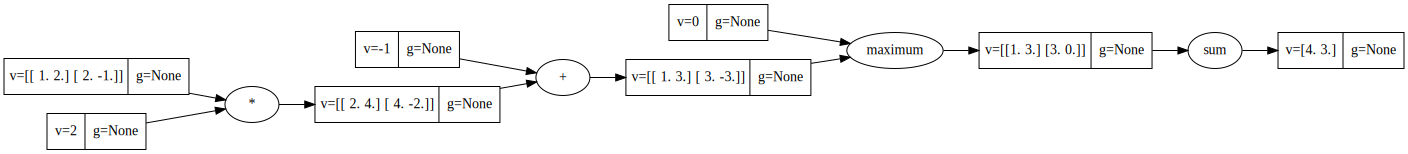

In [69]:
# a very simple example
x = Tensor([[1.0, 2.0],
            [2.0, -1.0]])
y = (x * 2 - 1).maximum(0).sum(axis=-1)
draw_dot(y)

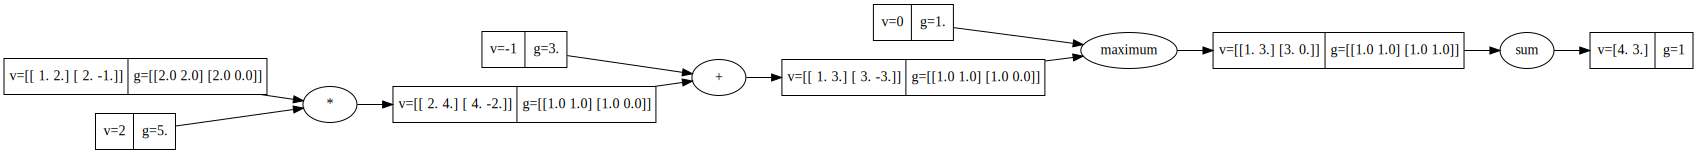

In [70]:
y.backward(np.ones_like(y))
draw_dot(y)

In [73]:
def f_np(x):
    b = [1, 0]
    return (x @ b)*np.exp((-x*x).sum(axis=-1))

def f_T(x):
    b = [1, 0]
    return (x @ b)*(-x*x).sum(axis=-1).exp()

def grad_f(x):
    xT = Tensor(x)
    y = f_T(xT)
    y.backward(np.ones_like(y.value))
    return xT.grad

[-0.00673795 -0.02695179]


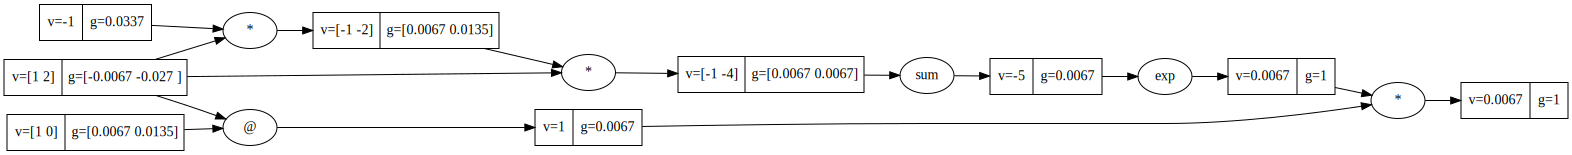

In [74]:
xT = Tensor([1, 2])
out = f_T(xT)
out.backward(1)
print(xT.grad)
draw_dot(out)

In [57]:
def numerical_jacobian(f, x, h=1e-10):
    n = x.shape[-1]
    eye = np.eye(n)
    x_plus_dx = x + h * eye # n x n
    num_jac = (f(x_plus_dx) - f(x)) / h # limit definition of the formula # n x m
    if num_jac.ndim >= 2:
        num_jac = num_jac.swapaxes(-1, -2) # m x n
    return num_jac

# Compare our grad_f with numerical gradient
def check_numerical_jacobian(f, jac_f,  nD=2, **kwargs):
    x = np.random.rand(nD)
    print(x)
    num_jac = numerical_jacobian(f, x, **kwargs)
    print(num_jac)
    print(jac_f(x))
    return np.allclose(num_jac, jac_f(x), atol=1e-06, rtol=1e-4) # m x n

## Throw error if grad_f is wrong
assert check_numerical_jacobian(f_np, grad_f)

[0.4717993  0.90549333]
[ 0.19560853 -0.30124125]
[ 0.19560835 -0.30124165]
